# Exercise: Integrated GPU (IGPU) and the DevCloud

Now that we've walked through the process of requesting a CPU on Intel's DevCloud and loading a model on the IGPU, you will have the opportunity to do this yourself with the addition of running inference on an image using both a CPU and IGPU.

On the previous page, we concluded that running the inference on the IGPU could potentially improve the performance enough that the client would not need to purchase any new hardware. However, we don't know for sure if this is the case—we need to test it. So in this exercise, we'll also investigate how batching affects the inference.

In this exercise, you will do the following:
1. Write a Python script to load a model and run inference 1000 times with and without batches.
    * Calculate the time it takes to load the model.
    * Calculate the time it takes to run inference 1000 times with a batch of 1.
    * Calculate the time it takes to run inference 100 times with a batch of 10.
2. Write a shell script to submit a job to Intel's DevCloud.
3. Submit two jobs using `qsub` on an edge node.
    * One job using `CPU` as the device with an **UP Squared Grove IoT Dev kit**.
    * One job using `GPU` as the device with an **UP Squared Grove IoT Dev kit**.
4. Run `liveQStat` to view the status of your submitted jobs.
5. Retrieve the results from your job.
6. View the results.
7. Plot and compare the results using bar graphs with `matplotlib` for the following metrics:
    * Model Loading Time
    * Inference Time
    * Frames Per Secone (FPS)

Click the **Exercise Overview** button below for a demonstration.

<span class="graffiti-highlight graffiti-id_q3u0ysu-id_m91okd5"><i></i><button>Exercise Overview</button></span>

#### IMPORTANT: Set up paths so we can run Dev Cloud utilities
You *must* run this every time you enter a Workspace session.

In [ ]:
%env PATH=/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/intel_devcloud_support
import os
import sys
sys.path.insert(0, os.path.abspath('/opt/intel_devcloud_support'))
sys.path.insert(0, os.path.abspath('/opt/intel'))

## The Model

We will be using the `vehicle-license-plate-detection-barrier-0106` model for this exercise.

Remember to use the appropriate model precisions for each device:

* CPU - `FP32`
* IGPU - `FP16`

The model has already been downloaded for you in the `/data/models/intel` directory on Intel's DevCloud.

We will be running inference on an image of a car. The path to the image is `/data/resources/car.png`.

# Step 1: Creating a Python Script

The first step is to create a Python script that you can use to load the model and perform inference. We'll use the `%%writefile` magic to create a Python file called `inference_on_device.py`. In the next cell, you will need to complete the `TODO` items for this Python script.

`TODO` items:

1. Load the model

2. Get the name of the input node

3. Prepare the model for inference (create an input dictionary)

4. Run inference 100 times in a loop when the batch size is 10, and 1000 times when the batch size is 1

If you get stuck, you can click on the **Show Solution** button below for a walkthrough with the solution code.

In [ ]:
%%writefile inference_on_device.py

import time
import numpy as np
import cv2
from openvino.inference_engine import IENetwork
from openvino.inference_engine import IECore
import argparse

def main(args):
    model=args.model_path
    model_weights=model+'.bin'
    model_structure=model+'.xml'
    batches=int(args.batches)
    
    start=time.time()
    
    # TODO: Load the model
       
    load_time=time.time()-start
    print(f"Time taken to load model = {load_time} seconds")
    
    # TODO: Get the name of the input node
    
    # Reading and Preprocessing Image
    input_img=cv2.imread('/data/resources/car.png')
    input_img=cv2.resize(input_img, (300,300), interpolation = cv2.INTER_AREA)
    input_img=np.moveaxis(input_img, -1, 0)
    
    # Running Inference in a loop on the same image
    input_dict={input_name:[input_img]*batches}
    
    if batches==1:
        iterations=1000
    else:
        iterations=100
    
    start=time.time()
    for _ in range(iterations):
        # TODO: Run Inference in a Loop
    
    # Calculate inference time and fps
    inference_time=time.time()-start
    fps=100/inference_time
    
    print(f"Time Taken to run 100 Inference is = {inference_time} seconds")
    
    # Write load time, inference time, and fps to txt file
    with open(f"/output/{args.path}.txt", "w") as f:
        f.write(str(load_time)+'\n')
        f.write(str(inference_time)+'\n')
        f.write(str(fps)+'\n')

if __name__=='__main__':
    parser=argparse.ArgumentParser()
    parser.add_argument('--model_path', required=True)
    parser.add_argument('--device', default=None)
    parser.add_argument('--path', default=None)
    parser.add_argument('--batches', default=None)
    
    args=parser.parse_args() 
    main(args)

In [ ]:
%%writefile inference_on_device.py

import time
import cv2
import numpy as np
from openvino.inference_engine import IENetwork
from openvino.inference_engine import IECore
import argparse

def main(args):
    model=args.model_path
    model_weights=model+'.bin'
    model_structure=model+'.xml'
    batches=int(args.batches)
    
    start=time.time()
    model=IENetwork(model_structure, model_weights)
    model.batch_size=batches

    core = IECore()
    net = core.load_network(network=model, device_name=args.device, num_requests=1)
    load_time=time.time()-start
    print(f"Time taken to load model = {load_time} seconds")
    
    # Get the name of the input node
    input_name=next(iter(model.inputs))

    # Reading and Preprocessing Image
    input_img=cv2.imread('/data/resources/car.png')
    input_img=cv2.resize(input_img, (300,300), interpolation = cv2.INTER_AREA)
    input_img=np.moveaxis(input_img, -1, 0)

    # Running Inference in a loop on the same image
    input_dict={input_name:[input_img]*batches}
    
    if batches==1:
        iterations=1000
    else:
        iterations=100

    start=time.time()
    for _ in range(iterations):
        net.infer(input_dict)
    
    inference_time=time.time()-start
    fps=100/inference_time
    
    print(f"Time Taken to run 1000 Inferences is = {inference_time} seconds")
    
    with open(f"/output/{args.path}.txt", "w") as f:
        f.write(str(load_time)+'\n')
        f.write(str(inference_time)+'\n')
        f.write(str(fps)+'\n')

if __name__=='__main__':
    parser=argparse.ArgumentParser()
    parser.add_argument('--model_path', required=True)
    parser.add_argument('--device', default=None)
    parser.add_argument('--path', default=None)
    parser.add_argument('--batches', default=None)
    
    args=parser.parse_args() 
    main(args)


<span class="graffiti-highlight graffiti-id_wz891hr-id_r4s1m8u"><i></i><button>Show Solution</button></span>

## Step 2: Creating a Job Submission Script

To submit a job to the DevCloud, you'll need to create a shell script. Similar to the Python script above, we'll use the `%%writefile` magic command to create a shell script called `inference_model_job.sh`. In the next cell, you will need to complete the `TODO` items for this shell script.

`TODO` items:
1. Create three variables:
    * `DEVICE` - Assign the value as the first argument passed into the shell script.
    * `BATCHES` - Assign the value as the second argument passed into the shell script
    * `MODELPATH` - Assign the value as the third argument passed into the shell script.
    * `SAVEPATH` - Assign the value as the fourth argument passed into the shell script.

2. Call the Python script using the three variable values as the command line argument

If you get stuck, you can click on the **Show Solution** button below for a walkthrough with the solution code.

In [ ]:
%%writefile inference_model_job.sh
#!/bin/bash

exec 1>/output/stdout.log 2>/output/stderr.log

mkdir -p /output

# TODO: Create DEVICE variable
# TODO: Create BATCHES variable
# TODO: Create MODELPATH variable
# TODO: Create SAVEPATH variable

# TODO: Call the Python script

cd /output

tar zcvf output.tgz * # compresses all files in the current directory (output)

<span class="graffiti-highlight graffiti-id_9puq2z1-id_s80y9b8"><i></i><button>Hide Solution</button></span>

In [ ]:
%%writefile inference_model_job.sh
#!/bin/bash

exec 1>/output/stdout.log 2>/output/stderr.log

mkdir -p /output

DEVICE=$1
BATCHES=$2
MODELPATH=$3
SAVEPATH=$4


# Run the load model python script
python3 inference_on_device.py  --model_path ${MODELPATH} --device ${DEVICE} --path ${SAVEPATH} --batches ${BATCHES}

cd /output

tar zcvf output.tgz *

## Step 3: Submitting a Job to Intel's DevCloud

In the next two sub-steps, you will write your `!qsub` commands to submit your jobs to Intel's DevCloud to load your model and run inference on the UP Squared Grove IoT Dev kit with an **Intel Atom x7-E3950** CPU and **Intel HD Graphics 505** IGPU.

Your `!qsub` command should take the following flags and arguments:
1. The first argument should be the shell script filename
2. `-d` flag - This argument should be `.`
3. `-l` flag - This argument should request an edge node with an **UP Squared Grove IoT Dev kit**. The node name for this is `up-squared`. The kit contains the following devices:
    * **Intel Atom x7-E3950** for your `CPU`
    * **Intel HD Graphics 505** for your `IGPU`
    
**Note**: Since this is a development kit with a predetermined set of hardware, you don't need to specify the CPU and GPU on your node request like we did in previous exercises.
4. `-F` flag - This argument should contain the three values to assign to the variables of the shell script:
    * **DEVICE** - Device type for the job: `CPU` or `GPU`
    * **BATCHES** - Batch size. `1 or 10`
    * **MODELPATH** - Full path to the model for the job. As a reminder, the model is located in `/data/models/intel`
    * **SAVEPATH** - Name of the file you want to save the performance metrics as. These should be named as the following:
        - `cpu_stats` for the `CPU` job without batching
        - `cpu_batch_stats`for the `CPU` job with batching
        - `gpu_stats` for the `GPU` job without batching
        - `gpu_batch_stats` for the `GPU` job with batching

**Note**: There is an optional flag, `-N`, you may see in a few exercises. This is an argument that only works on Intel's DevCloud that allows you to name your job submission. This argument doesn't work in Udacity's workspace integration with Intel's DevCloud.

## Step 3a: Running on the CPU

In the cell below, write the qsub command that will submit your job to the CPU with a batch size of 1.

If you get stuck, you can click on the **Show Solution** button below for a walkthrough with the solution code.

In [ ]:
cpu_job_id_core = # TODO: Write qsub command
print(cpu_job_id_core[0])

<span class="graffiti-highlight graffiti-id_6xf0emz-id_fx776ub"><i></i><button>Hide Solution</button></span>

In [5]:
cpu_job_id_core = !qsub inference_model_job.sh -d . -l nodes=1:up-squared -F "CPU 1 /data/models/intel/vehicle-license-plate-detection-barrier-0106/FP32/vehicle-license-plate-detection-barrier-0106 cpu_stats" -N store_core 
print(cpu_job_id_core[0])

xdp3dm2k7uNoJEoAzzPKV72mQbifjJrs


## Step 3b: Running on the CPU with Batches

In the cell below, write the qsub command that will submit your job to the CPU with a batch size of 10.

If you get stuck, you can click on the **Show Solution** button below for a walkthrough with the solution code.

In [6]:
gpu_job_id_core = # TODO: Write qsub command
print(gpu_job_id_core[0])

SyntaxError: invalid syntax (<ipython-input-6-31f202b10f4d>, line 1)

<span class="graffiti-highlight graffiti-id_8qggyrj-id_sga525q"><i></i><button>Hide Solution</button></span>

In [ ]:
cpu_batch_job_id_core = !qsub inference_model_job.sh -d . -l nodes=1:up-squared -F "CPU 10 /data/models/intel/vehicle-license-plate-detection-barrier-0106/FP32/vehicle-license-plate-detection-barrier-0106 cpu_batch_stats" -N store_core 
print(cpu_batch_job_id_core[0])

## Step 3c: Running on the GPU

In the cell below, write the qsub command that will submit your job to the GPU with a batch size of 1.

If you get stuck, you can click on the **Show Solution** button below for a walkthrough with the solution code.

In [ ]:
gpu_job_id_core = # TODO: Write qsub command
print(gpu_job_id_core[0])

<span class="graffiti-highlight graffiti-id_ch93k1d-id_75n0xif"><i></i><button>Hide Solution</button></span>

In [ ]:
gpu_job_id_core = !qsub inference_model_job.sh -d . -l nodes=1:up-squared -F "GPU 1 /data/models/intel/vehicle-license-plate-detection-barrier-0106/FP16/vehicle-license-plate-detection-barrier-0106 gpu_stats" -N store_core 
print(gpu_job_id_core[0])

## Step 3d: Running on the GPU with batches

In the cell below, write the qsub command that will submit your job to the GPU with a batch size of 10.

If you get stuck, you can click on the **Show Solution** button below for a walkthrough with the solution code.

In [ ]:
gpu_batch_job_id_core = # TODO: Write qsub command
print(gpu_batch_job_id_core[0])

<span class="graffiti-highlight graffiti-id_slynorm-id_0tfk8ba"><i></i><button>Hide Solution</button></span>

In [10]:
gpu_batch_job_id_core = !qsub inference_model_job.sh -d . -l nodes=1:up-squared -F "GPU 10 /data/models/intel/vehicle-license-plate-detection-barrier-0106/FP16/vehicle-license-plate-detection-barrier-0106 gpu_batch_stats" -N store_core 
print(gpu_batch_job_id_core[0])

a3pywxIbMZbg8qFMlI6BFfkMtYI8kceu


## Step 4: Running liveQStat

Running the `liveQStat` function, we can see the live status of our job. Running the this function will lock the cell and poll the job status 10 times. The cell is locked until this finishes polling 10 times or you can interrupt the kernel to stop it by pressing the stop button at the top: ![stop button](assets/interrupt_kernel.png)

* `Q` status means our job is currently awaiting an available node
* `R` status means our job is currently running on the requested node

**Note**: In the demonstration, it is pointed out that `W` status means your job is done. This is no longer accurate. Once a job has finished running, it will no longer show in the list when running the `liveQStat` function.

Click the **Running liveQStat** button below for a demonstration.

<span class="graffiti-highlight graffiti-id_qaq1b9g-id_e924r6s"><i></i><button>Running LiveQstat</button></span>

In [11]:
import liveQStat
liveQStat.liveQStat()

## Step 5: Retrieving Output Files

In this step, we'll be using the `getResults` function to retrieve our job's results. This function takes a few arguments.

1. `job id` - This values are stored in the variables for each job you submitted using the qsub command in **Step 3a**, **Step 3b**, **Step 3c**, and **Step 3d**: 
    * `cpu_job_id_core`
    * `cpu_batch_job_id_core`
    * `gpu_job_id_core`
    * `gpu_batch_job_id_core`

Remember that this value is an array with a single string, so we access the string value using `job_id_core[0]`.

2. `filename` - This value should match the filename of the compressed file we have in our `inference_model_job.sh` shell script.
3. `blocking` - This is an optional argument and is set to `False` by default. If this is set to `True`, the cell is locked while waiting for the results to come back. There is a status indicator showing the cell is waiting on results.

**Note**: The `getResults` function is unique to Udacity's workspace integration with Intel's DevCloud. When working on Intel's DevCloud environment, your job's results are automatically retrieved and placed in your working directory.

Click the **Retrieving Output Files** button below for a demonstration.

<span class="graffiti-highlight graffiti-id_6zhr5sh-id_yspqiev"><i></i><button>Retrieving Output Files</button></span>

### Step 5a: Get GPU Results

**Without batches**

In [12]:
import get_results

get_results.getResults(gpu_job_id_core[0], filename="output.tgz", blocking=True)

getResults() is blocking until results of the job (id:JCBxph9X8Dh4H1Gl9pzKZwvC2Agyiiv9) are ready.
Please wait...........................................................................................................................................................................Success!
output.tgz was downloaded in the same folder as this notebook.


In [13]:
!tar zxf output.tgz

In [14]:
!cat stdout.log

Time taken to load model = 230.71829652786255 seconds
Time Taken to run 1000 Inferences is = 15.533451795578003 seconds
gpu_stats.txt
stderr.log


In [15]:
!cat stderr.log

inference_on_device.py:16: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  model=IENetwork(model_structure, model_weights)


**With Batches**

In [16]:
import get_results

get_results.getResults(gpu_batch_job_id_core[0], filename="output.tgz", blocking=True)

getResults() is blocking until results of the job (id:a3pywxIbMZbg8qFMlI6BFfkMtYI8kceu) are ready.
Please wait...Success!
output.tgz was downloaded in the same folder as this notebook.


In [17]:
!tar zxf output.tgz

In [18]:
!cat stdout.log

Time taken to load model = 230.2168698310852 seconds
Time Taken to run 1000 Inferences is = 8.599220037460327 seconds
gpu_batch_stats.txt
stderr.log


In [19]:
!cat stderr.log

inference_on_device.py:16: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  model=IENetwork(model_structure, model_weights)


### Step 5b: Get CPU Results

**Without Batches**

In [20]:
import get_results

get_results.getResults(cpu_job_id_core[0], filename="output.tgz", blocking=True)

getResults() is blocking until results of the job (id:xdp3dm2k7uNoJEoAzzPKV72mQbifjJrs) are ready.
Please wait...Success!
output.tgz was downloaded in the same folder as this notebook.


In [21]:
!tar zxf output.tgz

In [22]:
!cat stdout.log

Time taken to load model = 1.3911805152893066 seconds
Time Taken to run 1000 Inferences is = 16.316025018692017 seconds
cpu_stats.txt
stderr.log


In [23]:
!cat stderr.log

inference_on_device.py:16: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  model=IENetwork(model_structure, model_weights)


**With Batches**

In [24]:
import get_results

get_results.getResults(cpu_batch_job_id_core[0], filename="output.tgz", blocking=True)

getResults() is blocking until results of the job (id:rbFOUiDF7G2jOsaL8wzHhCdEttVwTVeo) are ready.
Please wait...Success!
output.tgz was downloaded in the same folder as this notebook.


In [25]:
!tar zxf output.tgz

In [26]:
!cat stdout.log

Time taken to load model = 1.3258368968963623 seconds
Time Taken to run 1000 Inferences is = 13.730911493301392 seconds
cpu_batch_stats.txt
stderr.log


In [27]:
!cat stderr.log

inference_on_device.py:16: DeprecationWarning: Reading network using constructor is deprecated. Please, use IECore.read_network() method instead
  model=IENetwork(model_structure, model_weights)


## Step 6: View the Outputs

Can you plot the load time, inference time and the frames per second in the cell below?

<span class="graffiti-highlight graffiti-id_f66xl3r-id_x1irox2"><i></i><button>View the Output</button></span>

In [28]:
import matplotlib.pyplot as plt

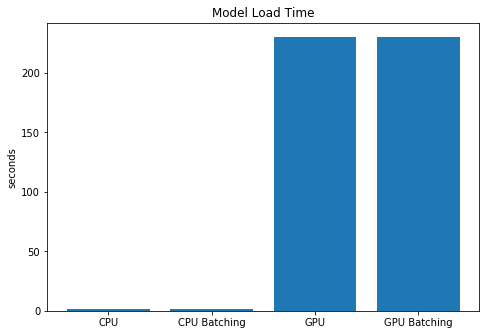

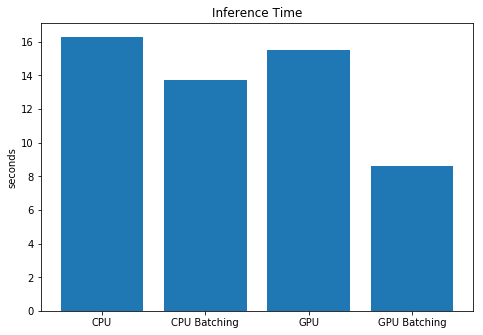

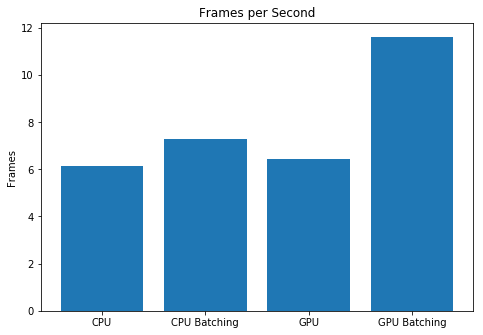

In [29]:
def plot(labels, data, title, label):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylabel(label)
    ax.set_title(title)
    ax.bar(labels, data)
    
def read_files(paths, labels):
    load_time=[]
    inference_time=[]
    fps=[]
    
    for path in paths:
        if os.path.isfile(path):
            f=open(path, 'r')
            load_time.append(float(f.readline()))
            inference_time.append(float(f.readline()))
            fps.append(float(f.readline()))

    plot(labels, load_time, 'Model Load Time', 'seconds')
    plot(labels, inference_time, 'Inference Time', 'seconds')
    plot(labels, fps, 'Frames per Second', 'Frames')

paths=['gpu_stats.txt', 'cpu_stats.txt', 'gpu_batch_stats.txt', 'cpu_batch_stats.txt']
read_files(paths, ['GPU', 'CPU', 'GPU Batching', 'CPU Batching'])

## Conclusion

We can see that batching the images leads to some improvement in **inference time** and **FPS** for both the CPU and GPU; however, we can see the improvement in performance for the GPU is much better.